# <center>Eye Tracking Project</center>

## Table of Contents

1. [Import Requirements](#Import-Requirements)
2. [Context Information](#Context-information)
3. [Paper 1: IPA](#The-Index-of-Pupillary-Activity)
    1. [Version 1](#Version-1) Hardcoded Version 
    2. [Version 2](#Version-2) PyWavelet Version
5. [Paper 2: LHIPA](#The-Low/High-Index-of-Pupillary-Activity)
6. [Paper 3: RIPA](#Toward-a-Real-Time-Index-of-Pupillary-Activity)
7. [PyPil Base Class](#Base-Class)
    1. [IPA Subclass](#IPA-Subclass)
    2. [LHIPA Subclass](#LHIPA-Subclass)
    3. [RIPA Theorectical Implementation](#Theoretical-Implementation)
8. [Lindlbauer Datasets](#Applied-to-the-Lindlbauer-Datasets)

## Import Requirements
These are the required packages to make the program work, I tried to limit it to only what was found within the original pseudocode with only a few additional ones where I thought they would be best used.

In [1]:
import glob
import math
import numpy as np
import os
import pandas as pd
import pywt

from matplotlib import pyplot as plt

## Context information
I will be trying to implement three pupillometric measures from Duchowski's papers regarding: 
- 1) Index of Pupillary Activity (IPA)
- 2) Low/High Index of Pupillary Activity (LHIPA)
- 3) Reat-Time-Index of Pupillary Activity (RIPA) 

Which are all loosely based on Marshall's Index of Cognitive Activity (ICA) from 2002.

## The Index of Pupillary Activity
The paper Duchowski et al. (2018) is the basis for this and it is the first iteration of their eye-tracked measure of the requency of pupil diameter oscillation. What this paper achieves is creating/replicating the Index of Cognitive Activity (ICA) and in general improving upon it without necessarily being copyrighted. 


## Version 1
This version was created before I was aware that PyWavelet could do 90% of what I needed for the code. This can be found on the Github under Unmaintained Code as Python Implementation v1. But is otherwise not up to date.

## Version 2
This version is the final one that is used within the implementation and is far cleaner code because of it.

### IPA Implementation
There are roughly six formulas that are used within the paper to calculate IPA. Below we will go through each one and how they are implemented, what their variables are, and how they connect to one another. 


### Wavelet Decomposition
All of the five formulas listed below construct the first part of our python implementation from the Duchowski et al. (2018) paper. Each of them will be noted in their explicit part in the end result but are as such not hardcode calculated in this current version of the project.

#### Dyadic Wavelet Function
The first of many functions, this one represents the wavelet function used in the analysis and is representative of the $wavelet$ argument in the function. For this specific rendition of the code, we assume that they are using the "sym16" version as that is what is used within the pseudo-code.

We will do this with the following variables:
- $x(t)$: pupil diameter signal over time
- $\psi(t)$: the mother wavelet function 
    - (Symlet-16)
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
\psi_{j,k}(t) = 2^{j/2} \psi(2^j t - k), \quad \text{where } j, k \in \mathbb{Z} \qquad \text{(0)}
$$

#### Integral Transformation of Wavelet Coefficients
This step is far more complicated as it goes through several iterations of it within the Duchowski et al. (2018) paper, but we'll mainly focus on the steps taht we can complete here.

(For the sake of space, repeated variables will not be given descriptions)

##### Decomposition of the Wavelet Analysis w.r.t. coefficients
This formula is implicit to our calculation but is not directly incorporated into our code.

Variable representation:
- $L^2(\mathbb{R})$: Noting that $x(t)$ is a square-integrable function
    - (meaning it won't become infinitely large when squared or integrated)
- $\sum_{j,k = -\infty}^{\infty}$: represents the sum over all possible combinations of j and k that are integers.
- $c_{j,k}$: wavelet coefficients of $\psi_{j,k}(t)$
- $x(t)$: pupil diameter signal
- $\psi_{j,k}(t)$: the mother wavelet function 
    - (Symlet-16)


$$
x \in L^2(\mathbb{R}): x(t) = \sum_{j,k = -\infty}^{\infty} c_{j,k} \psi_{j,k}(t), \quad j,k \in \mathbb{Z} \qquad \text{(1)}
$$

##### Inner Product Calculation of the Wavelet Coefficients
This formula computes the wavelet coefficients by taking the inner product of the input $x(t)$ and tells us how well the function performs at different scales and translations. From this formula onward, these are all explicitly done under the hood of "pywt.wavedec" which is the PyWavelet Decomposition function.

Variable representation:
- $c_{j,k}$: already noted
- $\int_{-\infty}^{\infty}$: Integral of the formula, represents area under the curve
- $x(t)$: already noted
- $\overline{\psi_{j,k}(t)}$: We are taking the complex conjugate of our previous wavelet function. 
    - (this ensures that the result is a real value)
- $dt$: The integration of the variable t

$$
c_{j,k} = \int_{-\infty}^{\infty} x(t) \overline{\psi_{j,k}(t)} dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z} \qquad \text{(2)}
$$

##### Substitution Property for Formula (0) and Formula (2)
Variables inlcuded from Formula (0):
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
c_{j,k} = 2^{j/2} \int_{-\infty}^{\infty} x(t) \overline{\psi(2^j t - k)} \, dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z}
\qquad \text{(3)}
$$

##### The Wavelet Coefficients in their final form
This formula gives us the similarity between the signal and the wavelet function at each scale and position.

Variable representation:
- $\{W_\psi x(t)\}(j, k)$: The wavelet transformation of $x(t)$ using $\psi$
- $\langle x(t), \psi_{j,k}(t) \rangle$: The inner product reprsented in another way from formula (3)

$$
= \{W_\psi x(t)\}(j, k) = \langle x(t), \psi_{j,k}(t) \rangle
\qquad \text{(4)}
$$

##### Modulus Maximum Detection
This formula is meant to identify the sharp poitns of variation within the signal, we do this after we have transformed the signal and determined the coefficients found in the previous formulas.
$$
\left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \leq \left| \langle x(t_0), \psi_{j,k} \rangle \right| \geq \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| 
$$

$$
\text{and} 
$$

$$
\quad \left\{ \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \quad \text{or} \quad \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| \right\} \qquad \text{(5)}
$$

#### Base Class

In [76]:
class PyPil:
    """
    Purpose: 
    This is the base class used to calculate three types of formulas 
    relating to pupil measurement with subclasses for each of the specific
    calculations. Since each of these calculations serve as an extension 
    of the previous one and as such is listed in the corresponding order 
    within the class and the only parts that are in this one are the items 
    shared by all three.
  
    The three papers and calculations in question and their subclass name:
    IPA:
    1) Index of Pupillary Activity (IPA) from Duchowski et al. (2018)
    
    LHIPA:
    2) Low/High Index of Pupillary Activity (LHIPA) from Duchowski et al. (2020)
    
    RIPA:
    3) Reat-Time-Index of Pupillary Activity (RIPA) from Jayawardena et al. (2022)
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
        
    ...
    
    Methods:
    calculate_timestamps()
        This returns the difference from the first and last point of measure.
   
    compute_modmax(cD2)
        
    
    compute_threshold(detect, mode="hard")
    
    calculate_ipa(cD2t)
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level = 2, specification="world_timestamp"):
        try:
            import numpy as np
            import math
            import pywt
        except ImportError as e:
            raise ImportError("A required library is not imported, verify that numpy, math, and pywt are imported.")
        
        self.pupil_data = pupil_data
        self.pupil_data_diam = list(pupil_data['diameter'])
        self.pupil_data_time_WI = list(pupil_data['world_index'])
        self.pupil_data_time_WT = list(pupil_data['world_timestamp'])
        self.wavelet = wavelet
        self.periodization = periodization
        self.level = level
        self.specification = specification
        
    # NOTE: This one is changed quite a lot from the original version in the 
    # psuedocode. This is because it uses timestamp compared to what the data 
    # we have.
    
    # CONCERN: The dataframes did not have an "actual" timestamp option, so 
    # I had to make do with what I had and the "world_index" was the closest
    # to it.
    
    # CONCERN 2: The Lindlbauer paper wants us to use a 60 row window to calculate
    # the IPA and then to shift it from there, this is far easier said than done.
    def calculate_timestamps(self):
        """
        Purpose: 
        This calculates the difference in time from the last point and the first point.
        
        ...
        
        Features:
        No input features
        
        ...
        
        Output:
        This will output a numeric value that is the difference in time between the two points.
        
        """
        tt = self.pupil_data[self.specification].iloc[-1] - self.pupil_data[self.specification].iloc[0]
#         tt = self.pupil_data[self.specification].idxmax()  - self.pupil_data[self.specification].idxmin() 

#         try:
#             tt = self.pupil_data_time[-1] - self.pupil_data_time[0]
#         except:
#             tt = pupil_data.shape[0]
#         tt = self.pupil_data.shape[0]
#         print("\nTimestamp Calculation:")
#         print("tt:", tt)
        return tt
        
    def compute_modmax(self, d):
        """
        Purpose:
        This will find where the modulus is grater than both of its 
        neighbours. 
        
        ...
        
        Features:
        cD2 : array
            This is the normalization of Detail coefficients at level 2
        
        ...
        
        Output:
        detect : array
        
        
        """    
        m = [0.0] * len(d)
        for i in range(len(d)):
            m[i] = math.fabs(d[i])
            
        t = [0.0] * len(d)
        for i in range(len(d)):    
            ll = m[i-1] if i >= 1 else m[i]
            oo = m[i]
            rr = m[i+1] if i < len(d)-2 else m[i]
            
            if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
                t[i] = math.sqrt(d[i]**2)
            else:
                t[i] = 0.0
#         print("\nModmax Calculation:")
#         print(detect)
        return t


    # CONCERN: whether we do hard or softe thresholding, everything
    # turns to 0 with this for every single dataframe we put inside.
    # I suspect this is a problem with my calculations.
    def compute_threshold(self, detect, mode="hard"):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        thresh = np.std(detect) * math.sqrt(2.0*np.log2(len(detect)))
        cD2t = pywt.threshold(detect,thresh,mode)
#         print("\nCalculate Threshold:")
#         print(cD2t)
        return cD2t
    
    def calculate_ipa(self, cD2t):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        ctr = 0
        for i in range(len(cD2t)):
            if math.fabs(cD2t[i]) > 0: 
                ctr += 1
        ipa = float(ctr)/ self.calculate_timestamps()
#         print("\nIPA:")
#         print(ipa)
        return ipa

#### IPA Subclass
Please note that after several revisions, these parts were to be partitioned into only the subclass that is below as LHIPA and RIPA were going to use part of the original IPA code but not all of it.

In [77]:
class IPA(PyPil):
    """
    Purpose: 
    This class calculates the Index of Pupillary Activity (IPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
        
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2, specification="world_timestamp"):
        super().__init__(pupil_data, wavelet, periodization, level, specification)
        
        # Perform IPA calculation upon initialization
        cA2, cD2, cD1 = self.ipa_wavelet_decomposition()
        cA2[:], cD2[:], cD1[:] = self.ipa_normalize_coefficients(cA2, cD2, cD1, self.level)
        detect = self.compute_modmax(cD2[:])
        cD2t = self.compute_threshold(detect)
        self.ipa = self.calculate_ipa(cD2t)
        print(f"IPA Calculation: {self.ipa}")

    def ipa_wavelet_decomposition(self):
        """
        Purpose: 
        This takes formula (0) to (4) from the paper and does it all with very minimal
        code. It takes sin the pupil diameter, uses sym16, per, and level 2 as its inputs 
        as they were listed in the original paper.
        
        ...
        
        Features:
        No input features
                
        ...
        
        Output:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        
        """
        # This was created to look like the one on the pseudocode in the paper
        cA2, cD2, cD1 = pywt.wavedec(self.pupil_data_diam, self.wavelet, mode=self.periodization, level=self.level)
#             print("Wavelet Decomposition:")
#             print("\n", "cA2:",  cA2)
#             print("\n", "cD2:", cD2)
#             print("\n", "cD1:", cD1)
        return cA2, cD2, cD1 
        
    def ipa_normalize_coefficients(self, cA2, cD2, cD1, level):
        """
        Purpose:
        This will normalize the coefficients for each one we created. 
        
        ...
        
        Features:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        level : int
            The level of granularity done within the decomposition (default: 2)
        
        ...
        
        Output:
        cA2[:] : array
            This is the normalization of Approximation coefficients at level 2
        cD2[:] : array
            This is the normalization of Detail coefficients at level 2
        cD1[:] : array
            This is the normalization of Detail coefficients at level 1
        
        """
        # normalize by 1/2 j , j = 2 for 2- level DWT
        # This is now changed to account for if we change the level
        cA2[:] = [x / math.sqrt(2.0 * level) for x in cA2] 
        cD2[:] = [x / math.sqrt(2.0 * level) for x in cD2]
        cD1[:] = [x / math.sqrt(1.0 * level) for x in cD1] 
        return cA2[:], cD2[:], cD1[:]        


### The Low/High Index of Pupillary Activity
This is the only version of the code that we'll have available for the LHIPA implementation. It is primarily utilizing the class PyPil to avoid reusing unchanged part of the code and the differences in formulas will be noted below and within the code itself.

#### Low Freq / High Freq Ratio
This part is the larger difference within the code is the LF/HF ratio. This is meant to characterize the autonomic balance of the frequencies. We do this by substituting $j$ with $\frac{1}{2} \log_2(n)$ and making sure to multipy the denominator by 2 to keep it balanced.

$$
\frac{(x_\psi^{\frac{1}{2} \log_2(n)} (t)}{x^1_\psi\left(2^{\frac{1}{2}\log_2(n)}t\right)} \qquad \text{(7)}
$$

We then plug this all into the very similar thresholding (but change its mode) and we get a brand new type of IPA calculation.

#### LHIPA Subclass

In [78]:
class LHIPA(PyPil):
    """
    Purpose: 
    This class calculates the Low/High Index of Pupillary Activity (LHIPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2, specification="world_timestamp"):
        super().__init__(pupil_data, wavelet, periodization, level, specification)
        
      
        # Perform LHIPA calculation upon initialization
        self.max_level = self.lhipa_wavelet_decomposition(self.pupil_data_diam)
        self.hif, self.lof = 1, int(self.max_level/2)
        cD_H, cD_L  = self.lhipa_normalize_coefficients(self.pupil_data_diam, self.max_level)
        cD_LH = self.lhipa_ratio(cD_H[:], cD_L[:])
        cD_LHm = self.compute_modmax(cD_LH)
        cD_LHt = self.compute_threshold(cD_LHm, mode="less")
        self.lhipa = self.calculate_ipa(cD_LHt)
        print(f"LHIPA Calculation: {self.lhipa}")
        
    def lhipa_wavelet_decomposition(self, d):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        w = pywt.Wavelet('sym16')
        self.max_level = pywt.dwt_max_level(len(d),filter_len=w.dec_len)
#         print("\n", "Max Level:")
#         print("\n", max_level)
        return self.max_level
        
    def lhipa_normalize_coefficients(self, d, max_level):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_H = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.hif)
        cD_L = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.lof)
        cD_H[:] = [x / math.sqrt(2**self.hif) for x in cD_H]
        cD_L[:] = [x / math.sqrt(2**self.lof) for x in cD_L]
        return cD_H[:], cD_L[:]   
    
    def lhipa_ratio(self, cD_H, cD_L):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_LH = cD_L.copy()
        for i in range(len(cD_L)):
            den = cD_H[((2**self.lof)//(2**self.hif))*i]
            if den != 0:
                cD_LH[i] = cD_L[i] / den
            else: 
                cD_LH[i] = cD_L[i] / 0.00000000001
        return cD_LH


### Toward a Real-Time Index of Pupillary Activity
Unlike the other two, the accesibility of the code or even psuedocode for RIPA is very limited and changes a lot of the fundamental parts of it. After doing some additional research on the content of the implementation, here is how it would roughly be done if we had the time and ability to ask some questions reqarding the code they used.

#### The Differences
There are many large differences between RIPA and the other two version of the implementation LH/IPA. Here are some of the most notable parts:

##### Real Time vs Offline
Fundamentally RIPA is meant to take on "Real-Time" whereas the original IPA and Low/High IPA take in data offline. 

##### Wavelet Analysis vs Savitzky-Golay filtering
LH/IPA use Dyadic/Discrete Wavelet Analysis and other scaling/translation transformations of the data, but RIPA just uses Savitzky-Golay filtering on the pupil diameter which allows for parallel computation of the low- and high-frequency responses. As noted in the paper by Jayawardena et al. (2022), this also in turn reduces the total complexity of the model as well.

##### Data Storage vs Ring Buffers
Effectively a Ring Buffer is a more efficient method for managing data when there is a fixed size to it. This is especially useful in Real Time applications because it allows for constant access to the data and FIFO behaviour for the items within it. There is definitely more to this, but my limited knowledge on Ring Buffers tell me that they are far better sutied to RT data which is why it was used over the original methodology.

##### Normalization Methods
The normalization process is a bit similar to that of LHIPA, but there is also the inclusion of a length buffer and inversion to make it directly proporitional to the pupil diameter. 


### Theoretical Implementation
Given we don't have the ability to do this in Real-Time and the psuedocode is not as easily readable/translatable into a class, here is what we would do given the option to implement it:

1. We would use the Python library collections.deque to create a ring buffer
2. We would then use the Python library scipy.signal for Savitzky-Golay filtering and apply this to the stored data in our collections.deque.
3. We then use a similar normalization process to the LHIPA on this data but also include the length buffer and inversion to get the low- and high-frequency responses.
4. We then apply the existing Modulus Maxima that we previously were using.
5. We then calculate the RIPA by counting when the ratio is outside our determined bounds.

### Applied to the Lindlbauer Datasets
We're going to use glob.glob again from the PyPil Dataframe Processor and iterate through the two groups of folders that the class created for us. Then we'll get both the IPA and LHIPA for each one and make some visualizations out of them. 

In the public Github version of this, there will be a directory that is noted after the os.chdir(r"...") , but for the sake of not showing my folder grouping I omitted it in the repo.

In [79]:
# This is the version where the ONLY thing we did to the data was remove NaNs/Nulls
# and we did nothing else to it.
os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\trimmed_files")
trim_csv_files = glob.glob("*.csv")
trim_csv_files

['study01_p02-pupil_positions-trimmed-02_trimmed.csv',
 'study01_p02-pupil_positions-trimmed_trimmed.csv',
 'study01_p02-pupil_positions_trimmed.csv',
 'study01_p03-pupil_positions_trimmed.csv',
 'study01_p04-pupil_positions_trimmed.csv',
 'study01_p05-pupil_positions_trimmed.csv',
 'study01_p06-pupil_positions_trimmed.csv',
 'study02_p01-pupil_positions_trimmed.csv',
 'study03_pupil_positions_trimmed.csv']

##### Over the Entire Dataset
Meaning that there is a single IPA/LHIPA for the entire timeframe (not the goal, just used as a benchmark)

In [80]:
ipa_list = []
lhipa_list = []

for csv in trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    ipa_list.append(ipa.ipa)
    lhipa_list.append(lhipa.lhipa)
    print("\n")


Name of File: study01_p02-pupil_positions-trimmed-02_trimmed.csv
IPA Calculation: 0.11701161691331395
LHIPA Calculation: 2.4572439551795933



Name of File: study01_p02-pupil_positions-trimmed_trimmed.csv
IPA Calculation: 0.07254175767359543
LHIPA Calculation: 2.42685152944392



Name of File: study01_p02-pupil_positions_trimmed.csv
IPA Calculation: 0.045451206856805586
LHIPA Calculation: 1.1799133300026732



Name of File: study01_p03-pupil_positions_trimmed.csv
IPA Calculation: 0.14050253926406184
LHIPA Calculation: 1.1513909386444547



Name of File: study01_p04-pupil_positions_trimmed.csv
IPA Calculation: 0.007402192973690859
LHIPA Calculation: 1.1491904591655058



Name of File: study01_p05-pupil_positions_trimmed.csv
IPA Calculation: 0.1445404835657436
LHIPA Calculation: 1.2137694453277188



Name of File: study01_p06-pupil_positions_trimmed.csv
IPA Calculation: 0.08332648204480758
LHIPA Calculation: 1.2054564402482164



Name of File: study02_p01-pupil_positions_trimmed.csv
IPA

In [81]:
# This is the version where we assumed that each data point was measured more than one time
# and we are averaging those measurements out.

# os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\grouped_trimmed_folder")
# grouped_trim_csv_files = glob.glob("*.csv")
# grouped_trim_csv_files

In [82]:
# g_ipa_list = []
# g_lhipa_list = []

# for csv in grouped_trim_csv_files:
#     print(f"\nName of File: {csv}")
    
#     df = pd.read_csv(csv)
#     ipa = IPA(df, specification="world_index")
#     lhipa = LHIPA(df, specification="world_index")
#     g_ipa_list.append(ipa.ipa)
#     g_lhipa_list.append(lhipa.lhipa)
#     print("\n")

There is at least a difference of 85 seconds between the first point and the last point, the catch is that this sliding window that the authors of Lindlbauer discuss is quite difficult to get done correctly.

In [83]:
df = pd.read_csv('study01_p02-pupil_positions-trimmed-02_trimmed.csv')

In [84]:
df.head(5), df.tail(5)

(   world_timestamp  world_index  diameter
 0    260229.466438            2       0.0
 1    260229.474838            2       0.0
 2    260229.483238            2       0.0
 3    260229.491638            3       0.0
 4    260229.500038            3       0.0,
       world_timestamp  world_index   diameter
 9994    260314.894438         2551  42.561084
 9995    260314.902838         2551  42.172867
 9996    260314.911238         2552  42.268218
 9997    260314.919638         2552  41.973641
 9998    260314.928038         2552  41.848515)

In [65]:
df['world_timestamp'].iloc[-1] - df['world_timestamp'].iloc[0]

85.46160000000964

It took some massive brute forcing, but there is indeed a 60 second difference only after we get to index 7001 of 9999. Which means that we don't have a very large window.

In [103]:
df['world_timestamp'].iloc[7001] - df['world_timestamp'].iloc[0]

60.00119999999879

In [ ]:
ipa_list = []
lhipa_list = []

for csv in trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    ipa_list.append(ipa.ipa)
    lhipa_list.append(lhipa.lhipa)
    print("\n")

In [108]:
def shifting_window_processing(df, window_size=7000):
    ipa_list = []
    lhipa_list = []
    # Iterate through the shifting window
    for i in range(len(df) - window_size + 1):
        subset = df.iloc[i:i+window_size]
        ipa = IPA(subset)  
        lhipa = LHIPA(subset) 
        ipa_list.append(ipa.ipa)
        lhipa_list.append(lhipa.lhipa)
        print("\n")
    return ipa_list, lhipa_list

In [111]:
ipa_list, lhipa_list = shifting_window_processing(df)

IPA Calculation: 0.16671001126963392
LHIPA Calculation: 4.8345903268193835


IPA Calculation: 0.21672301465041893
LHIPA Calculation: 4.701222317801395


IPA Calculation: 0.1833810123965083
LHIPA Calculation: 4.634538313293574


IPA Calculation: 0.21672301465052407
LHIPA Calculation: 4.8345903268193835


IPA Calculation: 0.166710011269553
LHIPA Calculation: 4.7178933189283505


IPA Calculation: 0.21672301465041893
LHIPA Calculation: 4.417815298643155


IPA Calculation: 0.1833810123965973
LHIPA Calculation: 4.617867312168859


IPA Calculation: 0.21672301465052407
LHIPA Calculation: 4.667880315549749


IPA Calculation: 0.166710011269553
LHIPA Calculation: 4.784577323436172


IPA Calculation: 0.21672301465052407
LHIPA Calculation: 4.701222317803676


IPA Calculation: 0.1833810123965973
LHIPA Calculation: 4.634538313295822


IPA Calculation: 0.21672301465041893
LHIPA Calculation: 4.801248324563127


IPA Calculation: 0.166710011269553
LHIPA Calculation: 4.6845513166744395


IPA Calculation: 

IPA Calculation: 0.10002600676178035
LHIPA Calculation: 4.8179193256924195


IPA Calculation: 0.10002600676178035
LHIPA Calculation: 4.684551316676712


IPA Calculation: 0.0833550056347765
LHIPA Calculation: 4.6845513166744395


IPA Calculation: 0.10002600676173182
LHIPA Calculation: 4.784577323436172


IPA Calculation: 0.10002600676178035
LHIPA Calculation: 4.717893318930639


IPA Calculation: 0.08335500563481696
LHIPA Calculation: 4.434486299772262


IPA Calculation: 0.0666840045078212
LHIPA Calculation: 4.651209314420529


IPA Calculation: 0.10002600676178035
LHIPA Calculation: 4.667880315549749


IPA Calculation: 0.08335500563481696
LHIPA Calculation: 4.8179193256924195


IPA Calculation: 0.10002600676173182
LHIPA Calculation: 4.667880315547484


IPA Calculation: 0.0666840045078212
LHIPA Calculation: 4.634538313293574


IPA Calculation: 0.08335500563481696
LHIPA Calculation: 4.8179193256924195


IPA Calculation: 0.08335500563481696
LHIPA Calculation: 4.701222317803676


IPA Calcula

LHIPA Calculation: 4.655773158717761


IPA Calculation: 0.3504345388282185
LHIPA Calculation: 4.67246051770958


IPA Calculation: 0.383809256811672
LHIPA Calculation: 4.789272030649994


IPA Calculation: 0.2669977438689892
LHIPA Calculation: 4.689147876699123


IPA Calculation: 0.2836851028609388
LHIPA Calculation: 4.70583523569322


IPA Calculation: 0.3504345388282185
LHIPA Calculation: 4.822646748635959


IPA Calculation: 0.383809256811672
LHIPA Calculation: 4.689147876699123


IPA Calculation: 0.2669977438691189
LHIPA Calculation: 4.455524850815921


IPA Calculation: 0.2836851028609388
LHIPA Calculation: 4.67246051770958


IPA Calculation: 0.3504345388280483
LHIPA Calculation: 4.705835235690935


IPA Calculation: 0.4004966158034838
LHIPA Calculation: 4.772584671658182


IPA Calculation: 0.2669977438691189
LHIPA Calculation: 4.655773158717761


IPA Calculation: 0.25031038487729895
LHIPA Calculation: 4.67246051770958


IPA Calculation: 0.3504345388280483
LHIPA Calculation: 4.805959389

IPA Calculation: 0.30037246185261285
LHIPA Calculation: 4.689147876699123


IPA Calculation: 0.2669977438691189
LHIPA Calculation: 4.78927203065232


IPA Calculation: 0.25031038487729895
LHIPA Calculation: 4.63908579972594


IPA Calculation: 0.23362302588536554
LHIPA Calculation: 4.705835235690935


IPA Calculation: 0.2836851028609388
LHIPA Calculation: 4.83933410762778


IPA Calculation: 0.2669977438691189
LHIPA Calculation: 4.75589731266868


IPA Calculation: 0.2503103848771774
LHIPA Calculation: 4.455524850813758


IPA Calculation: 0.233623025885479
LHIPA Calculation: 4.655773158717761


IPA Calculation: 0.30037246185275873
LHIPA Calculation: 4.6891478767014005


IPA Calculation: 0.2669977438689892
LHIPA Calculation: 4.805959389641806


IPA Calculation: 0.2503103848771774
LHIPA Calculation: 4.639085799723687


IPA Calculation: 0.233623025885479
LHIPA Calculation: 4.67246051770958


IPA Calculation: 0.2836851028609388
LHIPA Calculation: 4.856021466619599


IPA Calculation: 0.28368510

IPA Calculation: 0.30062530062525294
LHIPA Calculation: 4.659692159691421


IPA Calculation: 0.30062530062525294
LHIPA Calculation: 4.8267062155943385


IPA Calculation: 0.25052108385437744
LHIPA Calculation: 4.659692159691421


IPA Calculation: 0.23381967826419928
LHIPA Calculation: 4.726497782054885


IPA Calculation: 0.2839238950349611
LHIPA Calculation: 4.843407621184631


IPA Calculation: 0.26722248944466925
LHIPA Calculation: 4.776601998823463


IPA Calculation: 0.2505210838544992
LHIPA Calculation: 4.459275292610086


IPA Calculation: 0.23381967826408562
LHIPA Calculation: 4.659692159691421


IPA Calculation: 0.2839238950349611
LHIPA Calculation: 4.676393565281712


IPA Calculation: 0.2839238950349611
LHIPA Calculation: 4.893511837955506


IPA Calculation: 0.2505210838544992
LHIPA Calculation: 4.642990754103385


IPA Calculation: 0.26722248944466925
LHIPA Calculation: 4.6930949708720044


IPA Calculation: 0.30062530062525294
LHIPA Calculation: 4.843407621184631


IPA Calculation

IPA Calculation: 0.2842429106473143
LHIPA Calculation: 4.664927768858864


IPA Calculation: 0.33440342429112074
LHIPA Calculation: 4.698368111290246


IPA Calculation: 0.35112359550567673
LHIPA Calculation: 4.899010165864919


IPA Calculation: 0.2675227394327664
LHIPA Calculation: 4.69836811128796


IPA Calculation: 0.2842429106474526
LHIPA Calculation: 4.698368111290246


IPA Calculation: 0.33440342429112074
LHIPA Calculation: 4.8655698234358065


IPA Calculation: 0.35112359550550587
LHIPA Calculation: 4.798689138575247


IPA Calculation: 0.26752273943289656
LHIPA Calculation: 4.447565543071906


IPA Calculation: 0.2842429106474526
LHIPA Calculation: 4.664927768861134


IPA Calculation: 0.35112359550567673
LHIPA Calculation: 4.731808453719358


IPA Calculation: 0.3678437667200538
LHIPA Calculation: 4.899010165862535


IPA Calculation: 0.2508025682183405
LHIPA Calculation: 4.715088282504802


IPA Calculation: 0.2842429106474526
LHIPA Calculation: 4.68164794007569


IPA Calculation: 0.3

LHIPA Calculation: 4.67770605295184


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.727824332090609


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.911591355599432


IPA Calculation: 0.2505913956938486
LHIPA Calculation: 4.67770605295184


IPA Calculation: 0.2840035817863617
LHIPA Calculation: 4.67770605295184


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.811354797321893


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.794648704275636


IPA Calculation: 0.2505913956938486
LHIPA Calculation: 4.443820750304248


IPA Calculation: 0.28400358178622365
LHIPA Calculation: 4.660999959903317


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.711118239044353


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.945003541691945


IPA Calculation: 0.2505913956938486
LHIPA Calculation: 4.694412145998096


IPA Calculation: 0.2840035817863617
LHIPA Calculation: 4.67770605295184


IPA Calculation: 0.3174157678788749
LHIPA Calculation: 4.8280608

LHIPA Calculation: 4.644945697576825


IPA Calculation: 0.30075187969921885
LHIPA Calculation: 4.711779448621096


IPA Calculation: 0.3174603174602866
LHIPA Calculation: 4.928989139514976


IPA Calculation: 0.2506265664160157
LHIPA Calculation: 4.661654135337892


IPA Calculation: 0.2840434419381512
LHIPA Calculation: 4.695071010860028


IPA Calculation: 0.30075187969921885
LHIPA Calculation: 4.862155388470705


IPA Calculation: 0.31746031746044096
LHIPA Calculation: 4.8454469507119935


IPA Calculation: 0.2506265664160157
LHIPA Calculation: 4.427736006682944


IPA Calculation: 0.2840434419381512
LHIPA Calculation: 4.644945697576825


IPA Calculation: 0.3007518796993651
LHIPA Calculation: 4.728487886384463


IPA Calculation: 0.3174603174602866
LHIPA Calculation: 4.928989139514976


IPA Calculation: 0.2506265664160157
LHIPA Calculation: 4.67836257309896


IPA Calculation: 0.2840434419381512
LHIPA Calculation: 4.695071010860028


IPA Calculation: 0.3007518796993651
LHIPA Calculation: 4.8

LHIPA Calculation: 4.661654135340159


IPA Calculation: 0.30075187969921885
LHIPA Calculation: 4.745196324143231


IPA Calculation: 0.3341687552213543
LHIPA Calculation: 4.928989139514976


IPA Calculation: 0.26733500417708345
LHIPA Calculation: 4.67836257309896


IPA Calculation: 0.26733500417721345
LHIPA Calculation: 4.695071010862311


IPA Calculation: 0.30075187969921885
LHIPA Calculation: 4.862155388470705


IPA Calculation: 0.3341687552213543
LHIPA Calculation: 4.845446950709637


IPA Calculation: 0.26733500417721345
LHIPA Calculation: 4.46115288220725


IPA Calculation: 0.26733500417708345
LHIPA Calculation: 4.661654135337892


IPA Calculation: 0.30075187969921885
LHIPA Calculation: 4.7284878863821636


IPA Calculation: 0.3341687552213543
LHIPA Calculation: 4.928989139514976


IPA Calculation: 0.26733500417708345
LHIPA Calculation: 4.661654135337892


IPA Calculation: 0.26733500417708345
LHIPA Calculation: 4.695071010860028


IPA Calculation: 0.30075187969921885
LHIPA Calculatio

LHIPA Calculation: 4.713102424738985


IPA Calculation: 0.30083632498348584
LHIPA Calculation: 4.729815553907027


IPA Calculation: 0.33426258331498426
LHIPA Calculation: 4.863520587233021


IPA Calculation: 0.38440197081223193
LHIPA Calculation: 4.846807458067272


IPA Calculation: 0.26741006665185735
LHIPA Calculation: 4.4958317455843515


IPA Calculation: 0.30083632498348584
LHIPA Calculation: 4.713102424741278


IPA Calculation: 0.33426258331498426
LHIPA Calculation: 4.696389295575529


IPA Calculation: 0.3844019708120449
LHIPA Calculation: 4.947086233059361


IPA Calculation: 0.2674100666519874
LHIPA Calculation: 4.713102424741278


IPA Calculation: 0.30083632498348584
LHIPA Calculation: 4.729815553907027


IPA Calculation: 0.3509757124807335
LHIPA Calculation: 4.88023371639877


IPA Calculation: 0.38440197081223193
LHIPA Calculation: 4.846807458067272


IPA Calculation: 0.2674100666519874
LHIPA Calculation: 4.479118616420789


IPA Calculation: 0.28412319581773665
LHIPA Calculatio

LHIPA Calculation: 4.864203474144328


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.496463005308674


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.680333239726501


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.931065377568992


IPA Calculation: 0.26744761369878733
LHIPA Calculation: 4.697048715584952


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.864203474144328


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.51317848116484


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.663617763870334


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.931065377568992


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4

IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.663617763870334


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.646902288014169


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.880918950000494


IPA Calculation: 0.2507321378424911
LHIPA Calculation: 4.680333239726501


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.864203474144328


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.2507321378424911
LHIPA Calculation: 4.479747529452508


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.663617763870334


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.646902288014169


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.89763442585666


IPA Calculation: 0.2507321378426131
LHIPA Calculation: 4.663617763872604


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.334309

IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.680333239726501


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.931065377568992


IPA Calculation: 0.2507321378424911
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.880918950000494


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.2507321378424911
LHIPA Calculation: 4.479747529452508


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.3343095171234841
LHIPA Calculation: 4.680333239728778


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.931065377568992


IPA Calculation: 0.2507321378424911
LHIPA Calculation: 4.6970487155826675


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.3

IPA Calculation: 0.2839238950350991
LHIPA Calculation: 4.693094970874285


IPA Calculation: 0.3507295173962989
LHIPA Calculation: 4.676393565283985


IPA Calculation: 0.3507295173961284
LHIPA Calculation: 4.943616054726381


IPA Calculation: 0.25052108385437744
LHIPA Calculation: 4.709796376462296


IPA Calculation: 0.30062530062539905
LHIPA Calculation: 4.810004810006385


IPA Calculation: 0.3507295173961284
LHIPA Calculation: 4.8267062155943385


IPA Calculation: 0.3340281118058366
LHIPA Calculation: 4.793303404413755


IPA Calculation: 0.2505210838544992
LHIPA Calculation: 4.475976698200386


IPA Calculation: 0.2839238950349611
LHIPA Calculation: 4.6930949708720044


IPA Calculation: 0.3507295173961284
LHIPA Calculation: 4.676393565281712


IPA Calculation: 0.3340281118058366
LHIPA Calculation: 4.943616054726381


IPA Calculation: 0.2505210838544992
LHIPA Calculation: 4.709796376464586


IPA Calculation: 0.30062530062525294
LHIPA Calculation: 4.810004810004047


IPA Calculation: 0.3

LHIPA Calculation: 4.9644963292813244


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.30087856541098934
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.3844559446918197
LHIPA Calculation: 4.830772522431996


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.51317848116484


IPA Calculation: 0.30087856541098934
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.36774046883583256
LHIPA Calculation: 4.663617763872604


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.9644963292813244


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.30087856541098934
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.864203474144328


IPA Calculation: 0.3844559446918197
LHIPA Calculation: 4.830772522431996


IPA Calculation: 0.2841630895548233
LHIPA Calculatio

IPA Calculation: 0.3681022655021049
LHIPA Calculation: 4.835525215004923


IPA Calculation: 0.3848341866612915
LHIPA Calculation: 4.8187932938457365


IPA Calculation: 0.26771073854711575
LHIPA Calculation: 4.5176187129825776


IPA Calculation: 0.28444265970617194
LHIPA Calculation: 4.735133688049804


IPA Calculation: 0.3681022655021049
LHIPA Calculation: 4.651474082253871


IPA Calculation: 0.3848341866612915
LHIPA Calculation: 4.986112505437602


IPA Calculation: 0.26771073854698535
LHIPA Calculation: 4.7016698457314305


IPA Calculation: 0.28444265970617194
LHIPA Calculation: 4.75186560920899


IPA Calculation: 0.3681022655021049
LHIPA Calculation: 4.85225713616411


IPA Calculation: 0.3848341866612915
LHIPA Calculation: 4.85225713616411


IPA Calculation: 0.26771073854698535
LHIPA Calculation: 4.500886791821191


IPA Calculation: 0.28444265970617194
LHIPA Calculation: 4.735133688049804


IPA Calculation: 0.3848341866612915
LHIPA Calculation: 4.651474082253871


IPA Calculation: 0.

IPA Calculation: 0.3179065020245451
LHIPA Calculation: 4.718401766890617


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.8187932938457365


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.8187932938457365


IPA Calculation: 0.26771073854698535
LHIPA Calculation: 4.500886791821191


IPA Calculation: 0.3179065020245451
LHIPA Calculation: 4.718401766890617


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.651474082253871


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.986112505437602


IPA Calculation: 0.26771073854698535
LHIPA Calculation: 4.718401766890617


IPA Calculation: 0.3179065020245451
LHIPA Calculation: 4.75186560920899


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.80206137268655


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.835525215004923


IPA Calculation: 0.26771073854711575
LHIPA Calculation: 4.5176187129825776


IPA Calculation: 0.3179065020245451
LHIPA Calculation: 4.718401766890617


IPA Calculation: 0.35

IPA Calculation: 0.3510742873191344
LHIPA Calculation: 4.965193492084901


IPA Calculation: 0.28420299449658043
LHIPA Calculation: 4.680990497590736


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.764579613616824


IPA Calculation: 0.3510742873191344
LHIPA Calculation: 4.798015260028171


IPA Calculation: 0.35107428731930523
LHIPA Calculation: 4.848168729647549


IPA Calculation: 0.28420299449658043
LHIPA Calculation: 4.513812265533924


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.714426143999805


IPA Calculation: 0.3510742873191344
LHIPA Calculation: 4.647554851177113


IPA Calculation: 0.35107428731930523
LHIPA Calculation: 4.981911315292998


IPA Calculation: 0.28420299449644215
LHIPA Calculation: 4.680990497588459


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.764579613616824


IPA Calculation: 0.36779211052498645
LHIPA Calculation: 4.747861790413461


IPA Calculation: 0.36779211052498645
LHIPA Calculation: 4.848168729647549


IPA Calculation: 0

IPA Calculation: 0.3009208177021152
LHIPA Calculation: 4.714426143999805


IPA Calculation: 0.31763864090794286
LHIPA Calculation: 4.798015260030505


IPA Calculation: 0.35107428731930523
LHIPA Calculation: 4.7645796136191425


IPA Calculation: 0.3677921105248075
LHIPA Calculation: 4.814733083233843


IPA Calculation: 0.3009208177021152
LHIPA Calculation: 4.547247911943074


IPA Calculation: 0.334356464113624
LHIPA Calculation: 4.714426144002099


IPA Calculation: 0.3677921105248075
LHIPA Calculation: 4.614119204765767


IPA Calculation: 0.3677921105248075
LHIPA Calculation: 4.998629138496248


IPA Calculation: 0.30092081770226164
LHIPA Calculation: 4.680990497590736


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.814733083233843


IPA Calculation: 0.33435646411346137
LHIPA Calculation: 4.764579613616824


IPA Calculation: 0.33435646411346137
LHIPA Calculation: 4.831450906439517


IPA Calculation: 0.30092081770226164
LHIPA Calculation: 4.547247911945287


IPA Calculation: 0.

LHIPA Calculation: 4.981911315292998


IPA Calculation: 0.2674851712907691
LHIPA Calculation: 4.664272674382786


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.814733083233843


IPA Calculation: 0.3677921105248075
LHIPA Calculation: 4.764579613616824


IPA Calculation: 0.35107428731930523
LHIPA Calculation: 4.831450906441868


IPA Calculation: 0.2674851712907691
LHIPA Calculation: 4.563965735148748


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.714426143999805


IPA Calculation: 0.36779211052498645
LHIPA Calculation: 4.6475548511793745


IPA Calculation: 0.3510742873191344
LHIPA Calculation: 4.965193492084901


IPA Calculation: 0.2674851712907691
LHIPA Calculation: 4.664272674382786


IPA Calculation: 0.3176386409077883
LHIPA Calculation: 4.781297436822498


IPA Calculation: 0.36779211052498645
LHIPA Calculation: 4.7645796136191425


IPA Calculation: 0.3510742873191344
LHIPA Calculation: 4.831450906439517


IPA Calculation: 0.2674851712907691
LHIPA Calculation: 4

LHIPA Calculation: 4.818793293848083


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.75186560920899


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.835525215004923


IPA Calculation: 0.26771073854698535
LHIPA Calculation: 4.551082555298751


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.75186560920899


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.651474082253871


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.986112505437602


IPA Calculation: 0.26771073854711575
LHIPA Calculation: 4.718401766892915


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.80206137268655


IPA Calculation: 0.3681022655021049
LHIPA Calculation: 4.768597530368177


IPA Calculation: 0.3513703443429183
LHIPA Calculation: 4.835525215004923


IPA Calculation: 0.28444265970617194
LHIPA Calculation: 4.601278318776311


IPA Calculation: 0.3346384231837317
LHIPA Calculation: 4.768597530368177


IPA Calculation: 0.3681022655021049
LHIPA Calculation: 4.6347

LHIPA Calculation: 4.747195143151165


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.830772522431996


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.563324908733338


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.646902288014169


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.9644963292813244


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.730479667295


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.529893957021006


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.646902288014169


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.947780

LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.646902288014169


IPA Calculation: 0.35102499297965833
LHIPA Calculation: 4.931065377571391


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.730479667295


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.797341570719664


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.529893957021006


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.36774046883583256
LHIPA Calculation: 4.596755860447907


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.89763442585666


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.780

IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.730479667295


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.26744761369878733
LHIPA Calculation: 4.5633249087355585


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.613471336301837


IPA Calculation: 0.3844559446918197
LHIPA Calculation: 4.931065377568992


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.830772522431996


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.2674476136986572
LHIPA Calculation: 4.5466094328771725


IPA Calculation: 0.334

IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.747195143151165


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.59675586044567


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.59675586044567


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.89763442585666


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.713764191438833


IPA Calculation: 0.2841630895549615
LHIPA Calculation: 4.580040384591733


IPA Calculation: 0.33430

IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.59675586044567


IPA Calculation: 0.3844559446918197
LHIPA Calculation: 4.89763442585666


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.747195143151165


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3844559446920068
LHIPA Calculation: 4.730479667297301


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.580040384589505


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.8140570465758294


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.613471336301837


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.89763442585666


IPA Calculation: 0.30087856541098934
LHIPA Calculation: 4.780626094863497


IPA Calculation: 0.3175940412671554
LHIPA Calculation: 4.880918950000494


IPA Calculation: 0.3343095171234841
LHIPA Calculation: 4.797341570721997


IPA Calculation: 0.3677

LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.563324908733338


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.3175940412671554
LHIPA Calculation: 4.630186812158002


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.914349901712826


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3343095171234841
LHIPA Calculation: 4.880918950002869


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.3510249929794876
LHIPA Calculation: 4.763910619007332


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.5466094328771725


IPA Calculation: 0.3175940412671554
LHIPA Calculation: 4.847487998288162


IPA Calculation: 0.3343095171233215
LHIPA Calculation: 4.613471336301837


IPA Calculation: 0.36774046883565364
LHIPA Calculation: 4.9644963292813244


IPA Calculation: 0.2841630895548233
LHIPA Calculation: 4.8

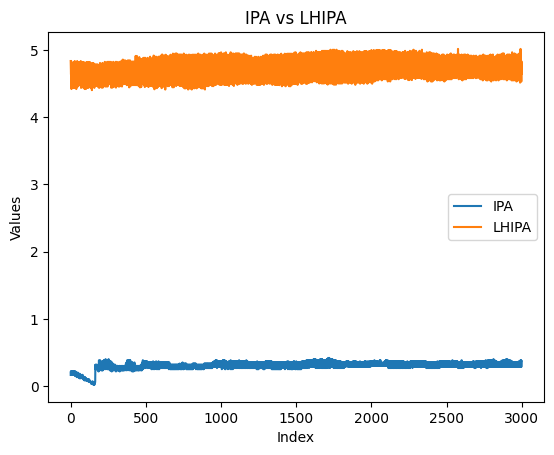

In [113]:
index = list(range(len(ipa_list)))

# Plot the lines
plt.plot(index, ipa_list, label='IPA')
plt.plot(index, lhipa_list, label='LHIPA')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('IPA vs LHIPA')
plt.legend()

# Show plot
plt.show()

In [1]:
!pip freeze > requirements.txt